In [1]:
!git clone https://github.com/PauloHFS/gpt2-from-scratch.git

Cloning into 'gpt2-from-scratch'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 206 (delta 75), reused 171 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (206/206), 1.26 MiB | 22.17 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
%cd gpt2-from-scratch

/content/gpt2-from-scratch


# GPT From Scratch

Este repositório irá implementar o GPT 2 do zero, com o código bruto do modelo presente na pasta `src`.

O objetivo será realizar o seguinte fluxo de atividades:
* Leitura do dataset;
* Treina modelo;
* Plotagem de métricas durante treino;
* Processa modelo para gerar textos;
* Avaliação dos textos;
* Plotagem da avaliação;
* Conclusão.

---

# Preparando ambiente

Importando pacotes python para utilização do código

In [3]:
# Importando pacotes python

from os import mkdir, environ
from os.path import exists

from json import load

Importando pacotes para execução do experimento

In [4]:
from src.dataload.tokenizer import Tokenizer
from src.gptmodel.model import GPTModel

---

# Configurações para rodar o sistema

Aqui ocorrerá as constantes para o processamento do sistema:

In [5]:
RESULT_DIR = "results"

if not exists(RESULT_DIR): mkdir(RESULT_DIR)

Diretório de banco de dados:

In [6]:
DATASET_DIR = "dataset/"

Caminho final dos tokens:

In [7]:
TOKEN_TEXTS = f"{RESULT_DIR}/tokens.txt"

Caminho do melhor modelo:

In [8]:
BEST_MODEL_PATH = f"{RESULT_DIR}/best_model.pt"

Configuração do GPT:

In [9]:
GPT_CONFIGURATION = f"src/gpt_configurations.json"

Estatísticas:

In [10]:
TRAIN_RATIO = 0.8
BATCH_SIZE = 5

Configuração:

In [11]:
with open(GPT_CONFIGURATION, 'r') as f:
    CONFIGURATION = load(f)

In [12]:
CONFIGURATION_KEY = "GPT_CONFIG_SMALL_COLAB"

In [13]:
configuration = CONFIGURATION[CONFIGURATION_KEY]

In [14]:
configuration

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 256,
 'n_heads': 8,
 'n_layers': 8,
 'drop_rate': 0.1,
 'qkv_bias': False,
 'attention_type': 'gqa',
 'num_kv_groups': 4}

Ambientes de execução:

In [15]:
environ['CUDA_LAUNCH_BLOCKING'] = "1"

---

# Leitura do Dataset

Tokenizando todo o conjunto de dados para treinamento e salvando em um arquivo de texto:

In [16]:
tokenizer = Tokenizer(["utf-8", "latin1"])

In [17]:
tokenizer.generate_data(DATASET_DIR, TOKEN_TEXTS)

100%|██████████| 10/10 [00:00<00:00, 603.09it/s]


Carregando base de dados:

In [18]:
with open(TOKEN_TEXTS, 'r') as f:
    contents = f.read()

In [19]:
train_dataloader, test_dataloader = tokenizer.create_dataloaders(
    contents,
    TRAIN_RATIO,
    BATCH_SIZE,
    configuration["context_length"],
    configuration["context_length"]
    )

---

# Treino dos modelos

Esta seção irá ocorrer a instanciação e geração dos modelos:

In [20]:
model = GPTModel(
    vocab_size=configuration["vocab_size"],
    emb_dim=configuration["emb_dim"],
    context_length=configuration["context_length"],
    drop_rate=configuration["drop_rate"],
    n_heads=configuration["n_heads"],
    n_layers=configuration["n_layers"],
    qkv_bias=configuration["qkv_bias"]
    )

In [21]:
trained_models, final_metrics = GPTModel._train(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    device_str="cuda",
    path=BEST_MODEL_PATH)

Training model on device: cuda


  0%|          | 0/1 [00:30<?, ?it/s]

Epoch 1/1 | Step 200 - Train Loss: 5.4648, Val Loss 5.1759, Throughput: 10775.6 tokens / sec


  0%|          | 0/1 [00:30<?, ?it/s]

New best model saved to results/best_model.pt with val_loss: 5.1759


  0%|          | 0/1 [01:00<?, ?it/s]

Epoch 1/1 | Step 400 - Train Loss: 4.6459, Val Loss 4.6252, Throughput: 11035.7 tokens / sec


  0%|          | 0/1 [01:01<?, ?it/s]

New best model saved to results/best_model.pt with val_loss: 4.6252


  0%|          | 0/1 [01:30<?, ?it/s]

Epoch 1/1 | Step 600 - Train Loss: 4.3412, Val Loss 4.4097, Throughput: 10062.5 tokens / sec


  0%|          | 0/1 [01:31<?, ?it/s]

New best model saved to results/best_model.pt with val_loss: 4.4097


100%|██████████| 1/1 [01:52<00:00, 112.51s/it]


---

# Análise de treinamento

Nesta seção irá ocorrer a análise do treinamento do modelo:

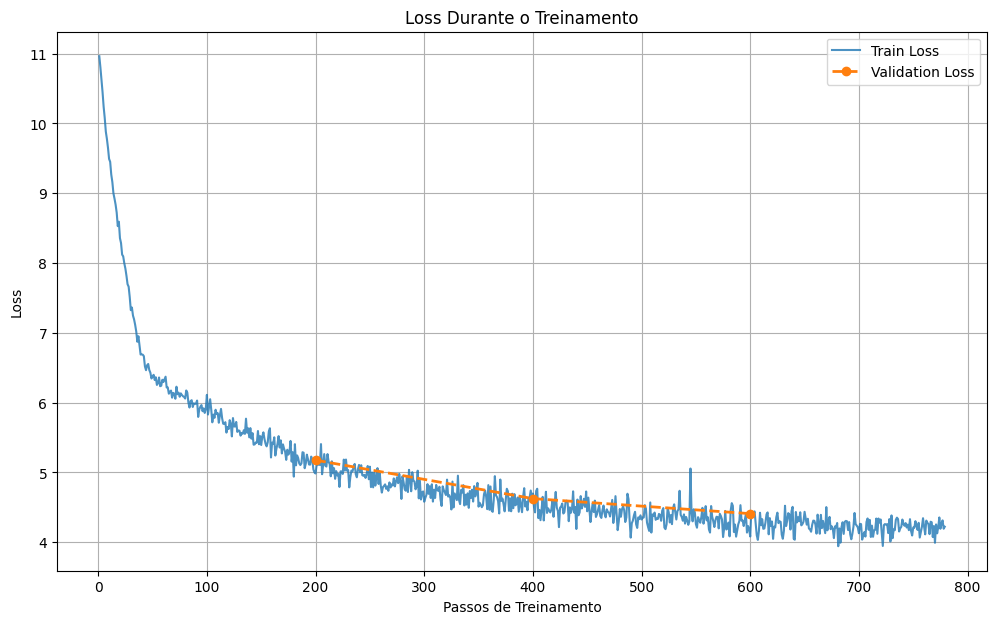

In [27]:
import matplotlib.pyplot as plt
import numpy as np

val_interval = 200

num_val_points = len(final_metrics.val_loss)
val_steps = np.arange(1, num_val_points + 1) * val_interval

fig = plt.figure(figsize=(12, 7))

plt.plot(
    np.arange(1, len(final_metrics.train_loss) + 1),
    final_metrics.train_loss,
    label='Train Loss',
    alpha=0.8
)

plt.plot(
    val_steps,
    final_metrics.val_loss,
    label='Validation Loss',
    marker='o',
    linestyle='--',
    linewidth=2
)

plt.xlabel('Passos de Treinamento')
plt.ylabel('Loss')
plt.title('Loss Durante o Treinamento')
plt.legend()
plt.grid(True)
plt.show()

---

# Geração de Textos para avaliação

Esta seção irá ocorrer a geração de textos para avaliação:

---

# Avaliação dos textos

Esta seção irá ocorrer a avaliação dos textos gerados pela LLM, tanto numericamente como graficamente.

---

# Conclusão

Por fim, aqui teremos uma seção de feedback a respeito das atividades desenvolvidas!